<a href="https://colab.research.google.com/github/maimonahST/GP/blob/main/NB_LightGBM_Adaboost(With%20Grid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np

data_array = np.load('/content/drive/MyDrive/GP-Data/data_array.npy')
label_array = np.load('/content/drive/MyDrive/GP-Data/label_array.npy')
group_array = np.load('/content/drive/MyDrive/GP-Data/group_array.npy')

print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import scipy.io
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin,BaseEstimator

In [ ]:
gkf=GroupKFold()
class StandardScaler3D(BaseEstimator,TransformerMixin):
    #batch, sequence, channels
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(-1, X.shape[2]))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape( -1,X.shape[2])).reshape(X.shape)


def three_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      train_features, train_label = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      train_features=scaler.fit_transform(train_features)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  # Split train_features into train and val
  for train_index, val_index in gkf.split(train_features, train_label, groups= train_groups):
      X_train, y_train =train_features[train_index],train_label[train_index]
      X_val, y_val =train_features[val_index],train_label[val_index]

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[val_index])}")

      break

  return X_train, X_val, X_test, y_train, y_val, y_test




def two_splits(data_array , label_array, group_array):

  # Split data_array into train and validate
  train_groups = []
  for train_index, test_index in gkf.split(data_array, label_array, groups=group_array):
      X_train, y_train = data_array[train_index],label_array[train_index]
      X_test, y_test =data_array[test_index],label_array[test_index]
      train_groups = group_array[train_index]

      scaler=StandardScaler3D()
      X_train=scaler.fit_transform(X_train)
      X_test=scaler.transform(X_test)

      print(f"group={np.unique(group_array[train_index])}")
      print(f"group={np.unique(group_array[test_index])}")
      break

  return X_train, X_test, y_train, y_test


# X_train, X_val, X_test, y_train, y_val, y_test = three_splits(data_array , label_array, group_array)

X_train, X_test, y_train, y_test = two_splits(data_array , label_array, group_array)

# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one

y_train[y_train==0] = 1
y_train[y_train==2] = 0

y_test[y_test==0] = 1
y_test[y_test==2] = 0

group=[ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19 20 22 23 25 27 28 29
 30 31 34 36 37 38 39 40 41 42 43 44 45 46 47]
group=[ 9 14 17 21 24 26 32 33 35]


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

def select_features_with_decision_tree(model,X_train, y_train, X_test, y_test, threshold=0.1):
    tree_params = {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
    # Train a Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(**tree_params)

    # Train a Decision Tree classifier to select important features
    #dt = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Select features based on importance using the trained Decision Tree
    sfm = SelectFromModel(dt_classifier, threshold=0.1)
    sfm.fit(X_train, y_train)

    # Transform the training and testing data to include only the selected features
    X_train_selected = sfm.transform(X_train)
    X_test_selected = sfm.transform(X_test)

    print(X_train_selected)
    print(X_test_selected)
    print("-------------------------")
    # Get indices of selected features
    selected_feature_indices = sfm.get_support(indices=True)

    # Get names of selected features
    selected_feature_names = [f"Feature {i+1}" for i in selected_feature_indices]

    # Print selected features
    print("Selected Features:")
    for feature in selected_feature_names:
        print(feature)

    model2=fit_and_evaluate(X_train_selected,y_train,X_test_selected,y_test,model)
    return model2

In [ ]:
def fit_and_evaluate(X_train, y_train, X_test, y_test,model):

  model.fit(X_train, y_train)

  # Predictions on the test set
  y_pred = model.predict(X_test)

  # Calculate evaluation metrics
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, average='weighted')
  recall = recall_score(y_test, y_pred, average='weighted')
  f1 = f1_score(y_test, y_pred, average='weighted')


  # Print the results
  print("Accuracy:", accuracy)
  print("Recall:", recall)
  print("Precision:", precision)
  print("F1-score:", f1)


  print("Classification Report (Test):\n", classification_report(y_test, y_pred))

  # Compute the confusion matrix for the test set
  cm_test = confusion_matrix(y_test, y_pred)

  # Plot the confusion matrix for the test set
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title(f"Confusion Matrix for Decision Tree {model.__class__}")
  plt.show()

  return model

In [ ]:
# Reshape data for compatibility with classifiers
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

## Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Create Bernoulli Naive Bayes classifier
bnb_classifier = BernoulliNB()

# Define the parameter grid for grid search
param_grid_bnb = {
    'alpha': [0.1, 0.5, 1.0],
    'binarize': [0.0, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Create GridSearchCV
grid_search_bnb = GridSearchCV(estimator=bnb_classifier, param_grid=param_grid_bnb,
                                cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
grid_search_bnb.fit(X_train, y_train)

# Get the best parameters and best estimator for Bernoulli Naive Bayes
best_params_bnb = grid_search_bnb.best_params_
best_bnb_classifier = grid_search_bnb.best_estimator_

# Print the best parameters for Bernoulli Naive Bayes
print("Best Hyperparameters for Bernoulli Naive Bayes:", best_params_bnb)

Best Hyperparameters for Bernoulli Naive Bayes: {'alpha': 0.1, 'binarize': 0.0, 'fit_prior': True}


In [ ]:
# Predictions on the test set using the best Bernoulli Naive Bayes model
best_bnb_test_predictions = best_bnb_classifier.predict(X_test)

# Calculate evaluation metrics for Bernoulli Naive Bayes
bnb_accuracy = accuracy_score(y_test, best_bnb_test_predictions)
bnb_precision = precision_score(y_test, best_bnb_test_predictions, average='weighted')
bnb_recall = recall_score(y_test, best_bnb_test_predictions, average='weighted')
bnb_f1 = f1_score(y_test, best_bnb_test_predictions, average='weighted')

# Print metrics for Bernoulli Naive Bayes
print("Accuracy:", bnb_accuracy)
print("Precision:", bnb_precision)
print("Recall:", bnb_recall)
print("F1-score:", bnb_f1)

Accuracy: 0.6926970354302241
Precision: 0.7617992630108333
Recall: 0.6926970354302241
F1-score: 0.5753222816395057


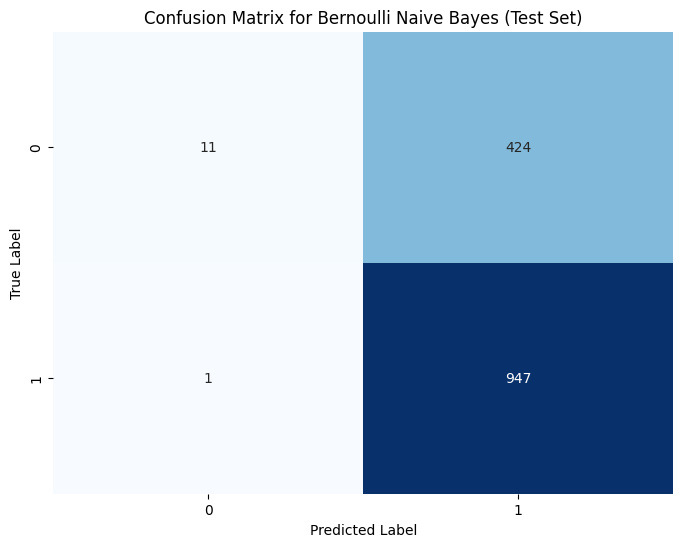

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, best_bnb_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Bernoulli Naive Bayes (Test Set)")
plt.show()

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/BNBWithHayperParameter.joblib'

# Save your model
joblib.dump(best_bnb_classifier, model_path)

['/content/drive/MyDrive/GP-Trail/BNBWithHayperParameter.joblib']

### With DT

[[-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071  0.18658284  0.1705135   0.18658284]
 ...
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763  8.73954447 -0.08673444 -0.15129016]]
[[-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 ...
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]]
-------------------------
Selected Features:
Feature 8217
Feature 20790
Feature 32934
Feature 34749
Accuracy: 0.6854663774403471
Recall: 0.6854663774403471
Precision: 0.46986415460119235
F1-score: 0.5575479414958807
Classification Report (Test):
               precision    recall

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

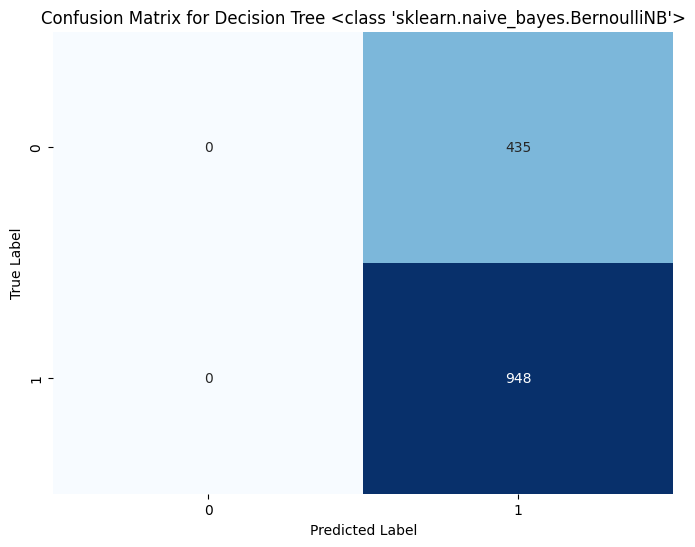

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

bnb_model=select_features_with_decision_tree(BernoulliNB(alpha=0.1, binarize=0.0, fit_prior=True),X_train, y_train,X_test , y_test)

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/BNBWithHayperParameter_DT.joblib'

# Save your model
joblib.dump(bnb_model, model_path)

['/content/drive/MyDrive/GP-Trail/BNBWithHayperParameter_DT.joblib']

## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Create Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# No hyperparameters to tune for Gaussian Naive Bayes, but you can include them if using other types

# Fit the model to the data
nb_classifier.fit(X_train, y_train)

# Predictions on the test set using the Naive Bayes model
nb_test_predictions = nb_classifier.predict(X_test)

# Calculate evaluation metrics for Naive Bayes
nb_accuracy = accuracy_score(y_test, nb_test_predictions)
nb_precision = precision_score(y_test, nb_test_predictions, average='weighted')
nb_recall = recall_score(y_test, nb_test_predictions, average='weighted')
nb_f1 = f1_score(y_test, nb_test_predictions, average='weighted')

# Print metrics for Naive Bayes
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1-score:", nb_f1)

Accuracy: 0.4953000723065799
Precision: 0.5687892174784692
Recall: 0.4953000723065799
F1-score: 0.5131117501674459


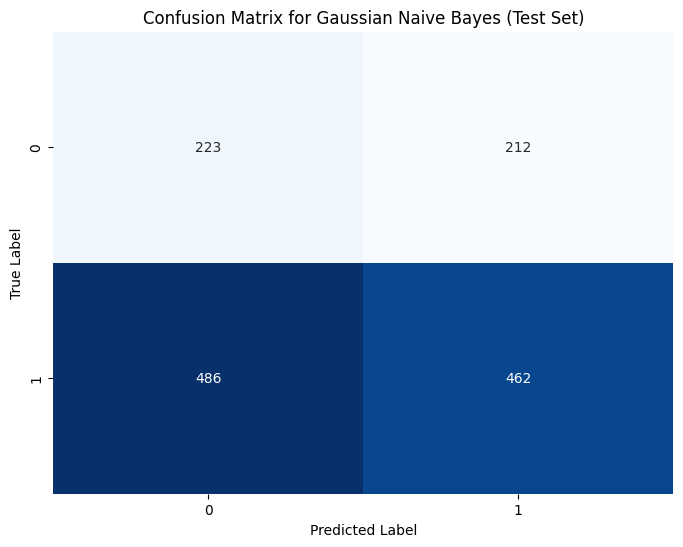

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, nb_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Gaussian Naive Bayes (Test Set)")
plt.show()

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/GNBWithHayperParameter.joblib'

# Save your model
joblib.dump(nb_classifier, model_path)

['/content/drive/MyDrive/GP-Trail/GNBWithHayperParameter.joblib']

### With DT

[[-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071  0.18658284  0.1705135   0.18658284]
 ...
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763  8.73954447 -0.08673444 -0.15129016]]
[[-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 ...
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]]
-------------------------
Selected Features:
Feature 8217
Feature 20790
Feature 32934
Feature 34749
Accuracy: 0.6760665220535069
Recall: 0.6760665220535069
Precision: 0.580339738024803
F1-score: 0.5709897885811627
Classification Report (Test):
               precision    recall  

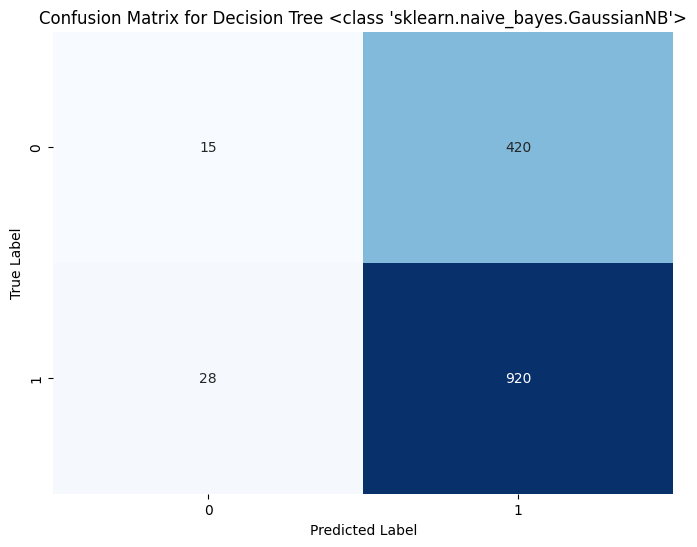

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

gnb_model=select_features_with_decision_tree(GaussianNB(),X_train, y_train,X_test , y_test)

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/GNBWithHayperParameter_DT.joblib'

# Save your model
joblib.dump(gnb_model, model_path)

['/content/drive/MyDrive/GP-Trail/GNBWithHayperParameter_DT.joblib']

## LightGBM

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search for LightGBM
lightgbm_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Create LGBMClassifier
lightgbm_classifier = LGBMClassifier(random_state=42)

# Create GridSearchCV for LightGBM
lightgbm_grid_search = GridSearchCV(estimator=lightgbm_classifier, param_grid=lightgbm_param_grid,
                                    cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
lightgbm_grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator for LightGBM
best_lightgbm_params = lightgbm_grid_search.best_params_
best_lightgbm_classifier = lightgbm_grid_search.best_estimator_

# Print the best parameters for LightGBM
print("Best Hyperparameters for LightGBM:", best_lightgbm_params)

# Predictions on the test set using the best LightGBM model
best_lightgbm_test_predictions = best_lightgbm_classifier.predict(X_test)

# Calculate evaluation metrics for LightGBM
lightgbm_accuracy = accuracy_score(y_test, best_lightgbm_test_predictions)
lightgbm_precision = precision_score(y_test, best_lightgbm_test_predictions, average='weighted')
lightgbm_recall = recall_score(y_test, best_lightgbm_test_predictions, average='weighted')
lightgbm_f1 = f1_score(y_test, best_lightgbm_test_predictions, average='weighted')

# Print metrics for LightGBM
print("Accuracy:", lightgbm_accuracy)
print("Precision:", lightgbm_precision)
print("Recall:", lightgbm_recall)
print("F1-score:", lightgbm_f1)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for LightGBM
lightgbm_params = {
    'learning_rate': 0.1,
    'n_estimators': 200,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Create LGBMClassifier with specified hyperparameters
lightgbm_classifier = LGBMClassifier(**lightgbm_params, random_state=42)

# Fit the model to the training data
lightgbm_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained LightGBM model
lightgbm_test_predictions = lightgbm_classifier.predict(X_test)

# Calculate evaluation metrics for LightGBM
lightgbm_accuracy = accuracy_score(y_test, lightgbm_test_predictions)
lightgbm_precision = precision_score(y_test, lightgbm_test_predictions, average='weighted')
lightgbm_recall = recall_score(y_test, lightgbm_test_predictions, average='weighted')
lightgbm_f1 = f1_score(y_test, lightgbm_test_predictions, average='weighted')

# Print metrics for LightGBM
print("Accuracy:", lightgbm_accuracy)
print("Precision:", lightgbm_precision)
print("Recall:", lightgbm_recall)
print("F1-score:", lightgbm_f1)

[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.523138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10272887
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 41250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for LightGBM
lightgbm_params = {
    'learning_rate': 0.1,
    'n_estimators': 200,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Create LGBMClassifier with specified hyperparameters
lightgbm_classifier = LGBMClassifier(**lightgbm_params, random_state=42)

# Fit the model to the training data
lightgbm_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained LightGBM model
lightgbm_test_predictions = lightgbm_classifier.predict(X_test)

# Calculate evaluation metrics for LightGBM
lightgbm_accuracy = accuracy_score(y_test, lightgbm_test_predictions)
lightgbm_precision = precision_score(y_test, lightgbm_test_predictions, average='weighted')
lightgbm_recall = recall_score(y_test, lightgbm_test_predictions, average='weighted')
lightgbm_f1 = f1_score(y_test, lightgbm_test_predictions, average='weighted')

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for LightGBM
lightgbm_params = {
    'learning_rate': 0.01,
    'n_estimators': 200,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Create LGBMClassifier with specified hyperparameters
lightgbm_classifier = LGBMClassifier(**lightgbm_params, random_state=42)

# Fit the model to the training data
lightgbm_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained LightGBM model
lightgbm_test_predictions = lightgbm_classifier.predict(X_test)

# Calculate evaluation metrics for LightGBM
lightgbm_accuracy = accuracy_score(y_test, lightgbm_test_predictions)
lightgbm_precision = precision_score(y_test, lightgbm_test_predictions, average='weighted')
lightgbm_recall = recall_score(y_test, lightgbm_test_predictions, average='weighted')
lightgbm_f1 = f1_score(y_test, lightgbm_test_predictions, average='weighted')

# Print metrics for LightGBM
print("Accuracy:", lightgbm_accuracy)
print("Precision:", lightgbm_precision)
print("Recall:", lightgbm_recall)
print("F1-score:", lightgbm_f1)

[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.894440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10272887
[LightGBM] [Info] Number of data points in the train set: 5767, number of used features: 41250
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.590602 -> initscore=0.366453
[LightGBM] [Info] Start training from score 0.366453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.6717281272595806
Precision: 0.7104022316657997
Recall: 0.6717281272595806
F1-score: 0.6821591529092444


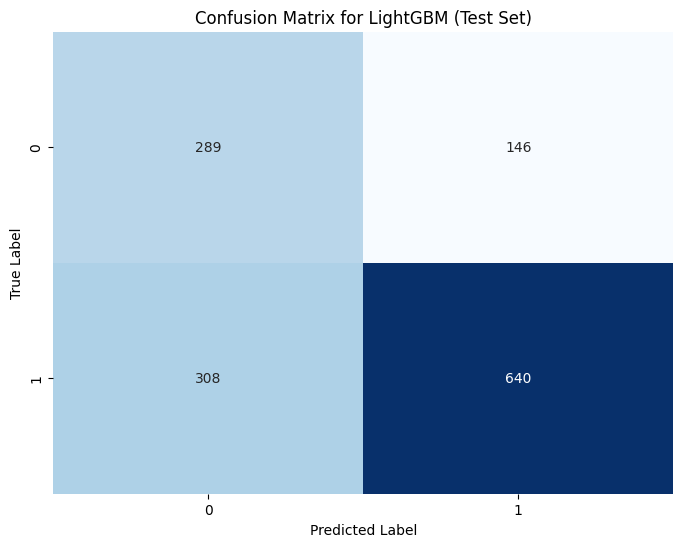

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, lightgbm_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for LightGBM (Test Set)")
plt.show()

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/LGBMWithHayperParameter.joblib'

# Save your model
joblib.dump(lightgbm_classifier, model_path)

['/content/drive/MyDrive/GP-Trail/LGBMWithHayperParameter.joblib']

### With DT

[[-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071  0.18658284  0.1705135   0.18658284]
 ...
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763  8.73954447 -0.08673444 -0.15129016]]
[[-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 ...
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]]
-------------------------
Selected Features:
Feature 8217
Feature 20790
Feature 32934
Feature 34749
[LightGBM] [Info] Number of positive: 3406, number of negative: 2361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can

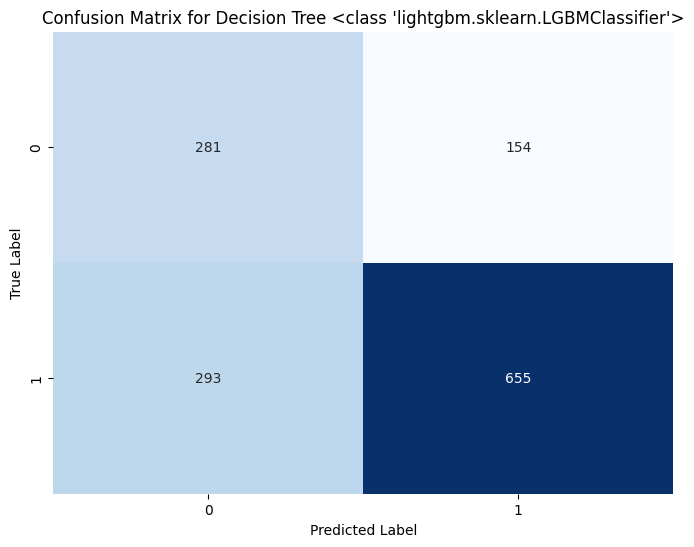

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for LightGBM
lightgbm_params = {
    'learning_rate': 0.01,
    'n_estimators': 200,
    'max_depth': -1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

lgbm_model=select_features_with_decision_tree(LGBMClassifier(**lightgbm_params, random_state=42),X_train, y_train,X_test , y_test)

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/LGBMWithHayperParameter_DT.joblib'

# Save your model
joblib.dump(lgbm_model, model_path)

['/content/drive/MyDrive/GP-Trail/LGBMWithHayperParameter_DT.joblib']

## Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

# Define the parameter grid to search for AdaBoost
adaboost_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Create AdaBoostClassifier
adaboost_classifier = AdaBoostClassifier(random_state=42)

# Create GridSearchCV for AdaBoost
adaboost_grid_search = GridSearchCV(estimator=adaboost_classifier, param_grid=adaboost_param_grid,
                                     cv=3, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the data
adaboost_grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator for AdaBoost
best_adaboost_params = adaboost_grid_search.best_params_
best_adaboost_classifier = adaboost_grid_search.best_estimator_

# Print the best parameters for AdaBoost
print("Best Hyperparameters for AdaBoost:", best_adaboost_params)

# Predictions on the test set using the best AdaBoost model
best_adaboost_test_predictions = best_adaboost_classifier.predict(X_test)

# Calculate evaluation metrics for AdaBoost
adaboost_accuracy = accuracy_score(y_test, best_adaboost_test_predictions)
adaboost_precision = precision_score(y_test, best_adaboost_test_predictions, average='weighted')
adaboost_recall = recall_score(y_test, best_adaboost_test_predictions, average='weighted')
adaboost_f1 = f1_score(y_test, best_adaboost_test_predictions, average='weighted')

# Print metrics for AdaBoost
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1-score:", adaboost_f1)

Best Hyperparameters for AdaBoost: {'learning_rate': 1.0, 'n_estimators': 200}
Accuracy: 0.3600867678958785
Precision: 0.3658759442286097
Recall: 0.3600867678958785
F1-score: 0.3629582732220019


In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, best_adaboost_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adaboost (Test Set)")
plt.show()

In [ ]:

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/AdaboostWithHayperParameter.joblib'

# Save your model
joblib.dump(best_adaboost_classifier, model_path)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for AdaBoost
adaboost_params = {
    'n_estimators': 200,  # Number of weak learners
    'learning_rate': 1.0  # Weighting of weak learners
}

# Create AdaBoostClassifier with specified hyperparameters
adaboost_classifier = AdaBoostClassifier(**adaboost_params, random_state=42)

# Fit the model to the training data
adaboost_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained AdaBoost model
adaboost_test_predictions = adaboost_classifier.predict(X_test)

# Calculate evaluation metrics for AdaBoost
adaboost_accuracy = accuracy_score(y_test, adaboost_test_predictions)
adaboost_precision = precision_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_recall = recall_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_f1 = f1_score(y_test, adaboost_test_predictions, average='weighted')

# Print metrics for AdaBoost
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1-score:", adaboost_f1)

Accuracy: 0.3600867678958785
Precision: 0.3658759442286097
Recall: 0.3600867678958785
F1-score: 0.3629582732220019


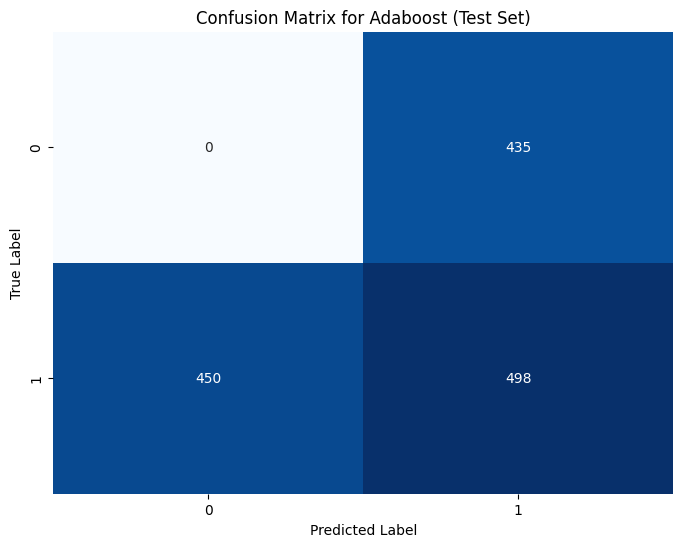

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, adaboost_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adaboost (Test Set)")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for AdaBoost
adaboost_params = {
    'n_estimators': 100,  # Number of weak learners
    'learning_rate': 1.0  # Weighting of weak learners
}

# Create AdaBoostClassifier with specified hyperparameters
adaboost_classifier = AdaBoostClassifier(**adaboost_params, random_state=42)

# Fit the model to the training data
adaboost_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained AdaBoost model
adaboost_test_predictions = adaboost_classifier.predict(X_test)

# Calculate evaluation metrics for AdaBoost
adaboost_accuracy = accuracy_score(y_test, adaboost_test_predictions)
adaboost_precision = precision_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_recall = recall_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_f1 = f1_score(y_test, adaboost_test_predictions, average='weighted')

# Print metrics for AdaBoost
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1-score:", adaboost_f1)

Accuracy: 0.3152566883586406
Precision: 0.3431266826222633
Recall: 0.3152566883586406
F1-score: 0.32860180380867654


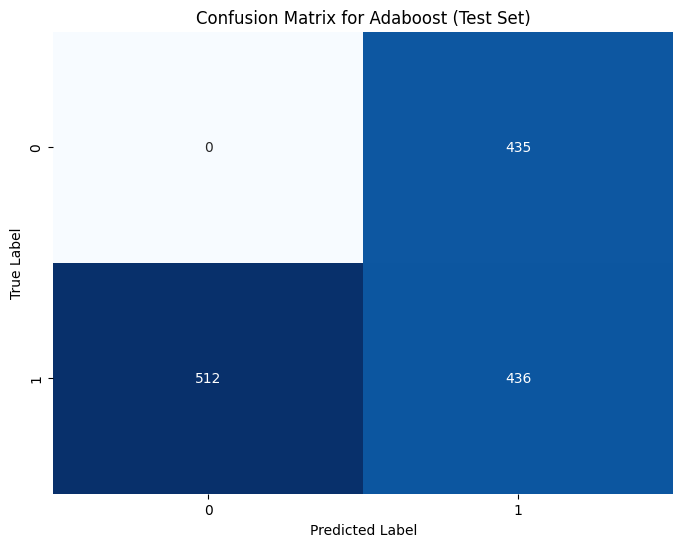

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, adaboost_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adaboost (Test Set)")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for AdaBoost
adaboost_params = {
    'n_estimators': 200,  # Number of weak learners
    'learning_rate': 0.1  # Weighting of weak learners
}

# Create AdaBoostClassifier with specified hyperparameters
adaboost_classifier = AdaBoostClassifier(**adaboost_params, random_state=42)

# Fit the model to the training data
adaboost_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained AdaBoost model
adaboost_test_predictions = adaboost_classifier.predict(X_test)

# Calculate evaluation metrics for AdaBoost
adaboost_accuracy = accuracy_score(y_test, adaboost_test_predictions)
adaboost_precision = precision_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_recall = recall_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_f1 = f1_score(y_test, adaboost_test_predictions, average='weighted')

# Print metrics for AdaBoost
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1-score:", adaboost_f1)

Accuracy: 0.32682574114244395
Precision: 0.3561482709138597
Recall: 0.32682574114244395
F1-score: 0.34073113659213494


In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, adaboost_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adaboost (Test Set)")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for AdaBoost
adaboost_params = {
    'n_estimators': 100,  # Number of weak learners
    'learning_rate': 0.5  # Weighting of weak learners
}

# Create AdaBoostClassifier with specified hyperparameters
adaboost_classifier = AdaBoostClassifier(**adaboost_params, random_state=42)

# Fit the model to the training data
adaboost_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained AdaBoost model
adaboost_test_predictions = adaboost_classifier.predict(X_test)

# Calculate evaluation metrics for AdaBoost
adaboost_accuracy = accuracy_score(y_test, adaboost_test_predictions)
adaboost_precision = precision_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_recall = recall_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_f1 = f1_score(y_test, adaboost_test_predictions, average='weighted')

# Print metrics for AdaBoost
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1-score:", adaboost_f1)

Accuracy: 0.47360809833694867
Precision: 0.42431737211039655
Recall: 0.47360809833694867
F1-score: 0.4471631718486382


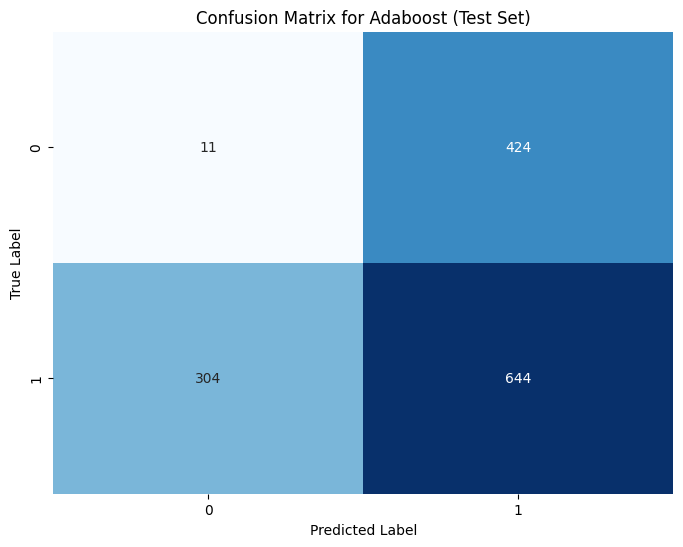

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, adaboost_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adaboost (Test Set)")
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for AdaBoost
adaboost_params = {
    'n_estimators': 200,  # Number of weak learners
    'learning_rate': 0.5  # Weighting of weak learners
}

# Create AdaBoostClassifier with specified hyperparameters
adaboost_classifier = AdaBoostClassifier(**adaboost_params, random_state=42)

# Fit the model to the training data
adaboost_classifier.fit(X_train, y_train)

# Predictions on the test set using the trained AdaBoost model
adaboost_test_predictions = adaboost_classifier.predict(X_test)

# Calculate evaluation metrics for AdaBoost
adaboost_accuracy = accuracy_score(y_test, adaboost_test_predictions)
adaboost_precision = precision_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_recall = recall_score(y_test, adaboost_test_predictions, average='weighted')
adaboost_f1 = f1_score(y_test, adaboost_test_predictions, average='weighted')

# Print metrics for AdaBoost
print("Accuracy:", adaboost_accuracy)
print("Precision:", adaboost_precision)
print("Recall:", adaboost_recall)
print("F1-score:", adaboost_f1)

Accuracy: 0.4005784526391902
Precision: 0.4038781856711347
Recall: 0.4005784526391902
F1-score: 0.4022177004829958


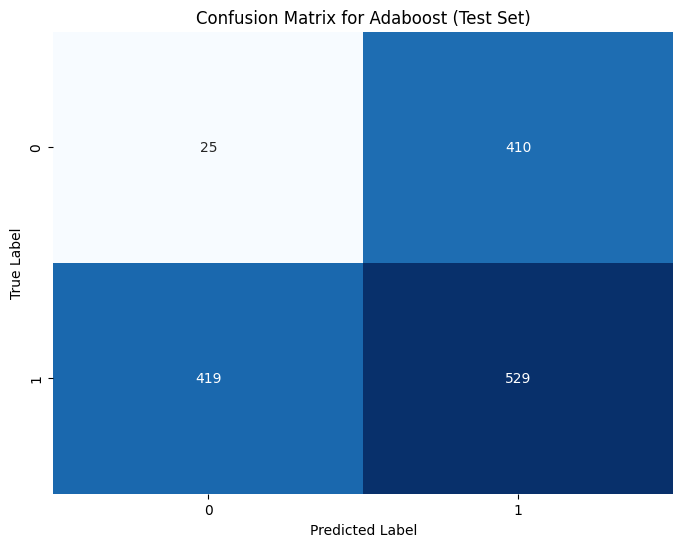

In [ ]:
# Compute the confusion matrix for the test set
cm_test = confusion_matrix(y_test, adaboost_test_predictions)

# Plot the confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adaboost (Test Set)")
plt.show()

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/AdaboostWithHayperParameter.joblib'

# Save your model
joblib.dump(adaboost_classifier, model_path)

['/content/drive/MyDrive/GP-Trail/AdaboostWithHayperParameter.joblib']

### With DT

[[-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071 -4.19766329 -4.14916175 -4.19766329]
 [-3.92122071  0.18658284  0.1705135   0.18658284]
 ...
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763 -0.12309218 -0.08673444 -0.15129016]
 [-0.17531763  8.73954447 -0.08673444 -0.15129016]]
[[-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 [-1.47669020e-01 -3.20702906e-13 -1.20165967e-01 -8.46864627e-02]
 ...
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]
 [-8.61341994e-02 -1.22234380e-01 -1.95253142e-01 -1.50228465e-01]]
-------------------------
Selected Features:
Feature 8217
Feature 20790
Feature 32934
Feature 34749
Accuracy: 0.3767172812725958
Recall: 0.3767172812725958
Precision: 0.4505986395547928
F1-score: 0.3985541399996954
Classification Report (Test):
               precision    recall 

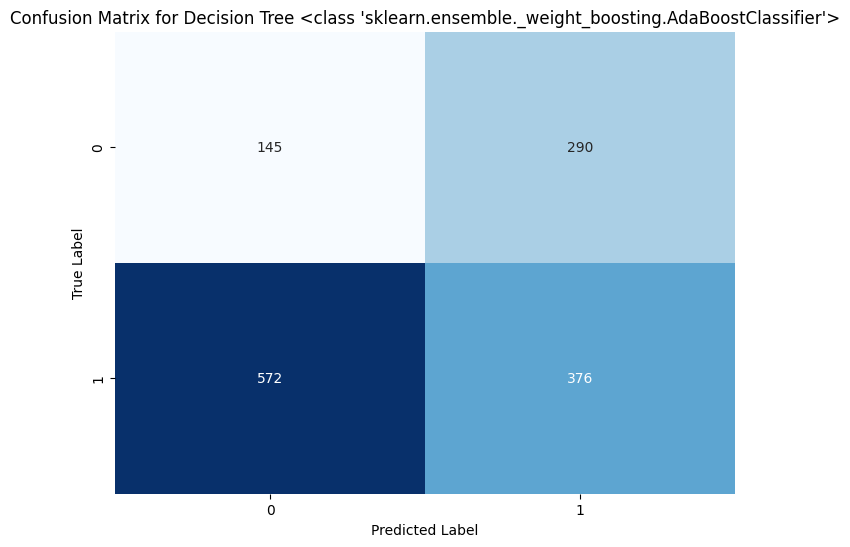

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define hyperparameters for AdaBoost
adaboost_params = {
    'n_estimators': 200,  # Number of weak learners
    'learning_rate': 1.0  # Weighting of weak learners
}

adaboost_model=select_features_with_decision_tree(AdaBoostClassifier(**adaboost_params, random_state=42),X_train, y_train,X_test , y_test)

In [ ]:
import joblib

# Specify the full path including the filename and .joblib extension
model_path = '/content/drive/MyDrive/GP-Trail/AdaboostWithHayperParameter_DT.joblib'

# Save your model
joblib.dump(adaboost_model, model_path)

['/content/drive/MyDrive/GP-Trail/AdaboostWithHayperParameter_DT.joblib']